# MAT dSTRF twin experiment

This script runs a twin experiment with a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf

from neurofit import utils as nfutils

import cneurons as cn


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [2]:
class cosstrf():
    def __init__(self, channels, nspec, tlen, ncos=10,tcoslin=1,normalize=False,center=False):
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.cosbas = utils.cosbasis(tlen,ncos,lin=tcoslin)
        self.invbas = np.linalg.pinv(self.cosbas)
        self.tfilt = None
        self.sfilt = None
        self.filt = None
        self.normalize = normalize
        self.center = center
        
    def dim(self):
        return self.channels*(self.nspec+self.ncos)

    def set(self,theta):
        flat_sfilt = theta[:self.nspec*self.channels]
        flat_tfilt = theta[self.nspec*self.channels:]
        self.sfilt = np.reshape(flat_sfilt,(self.channels,self.nspec))
        self.tfilt = np.matmul(self.cosbas,np.reshape(flat_tfilt,(self.channels,self.ncos)).T).T
        self.filt  = np.matmul(self.sfilt.T,self.tfilt)

    def run(self,stim):
        r = utils.spgconv(self.filt,stim)
        if self.normalize: r = nfutils.normalize(r,center=self.center,fn=np.var)
        return r

class mat():
    def __init__(self, free_ts=False,stochastic=False):
        self.nrn = None
        self.free_ts = free_ts
        self.stochastic = stochastic

    def dim(self):
        return 6 if self.free_ts else 4

    def set(self, theta):
        a, b, c, w = theta[:4]
        if self.stochastic:
            self.nrn = cn.augmatsto(a,b,c,5)
        else:
            self.nrn = cn.augmat(a, b, c,5)

        if self.free_ts:
            t1, t2 = theta[4:]
            self.nrn.t1 = t1
            self.nrn.t2 = t2
            
        self.nrn.R = w
        self.nrn.tm = 1
        
    def run(self, iapp):
        self.nrn.apply_current(iapp, 1)
        return self.nrn.simulate(len(iapp), 1)
    
# combining the strf and mat models
class dstrf_mat():
    def __init__(self,channels=1,nspec=15,tlen=30,ncos=10,coslin=1,upsample=1,
                 scale=1,free_ts=False,normalize=False,center=False,noise=None,stochastic=False):
        self.mat = mat(free_ts=free_ts,stochastic=stochastic)
        self.pstrf = cosstrf(channels,nspec,tlen,ncos,coslin,normalize,center)
        self.upsample = upsample
        self.scale = scale
        self.free_ts = free_ts
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.noise = noise
    def dim(self):
        return self.channels*(self.nspec+self.ncos) + ( 6 if self.free_ts else 4 )
     
    def set(self, theta):
        cut = -6 if self.free_ts else -4
        self.pstrf.set(theta[:cut])
        self.mat.set(theta[cut:])
        self.mat.nrn.R = 1
        self.mat.nrn.tm = 1
        
    def run(self, stim):
        r = self.pstrf.run(stim)
        if self.noise is not None: r += np.random.randn(len(r))*self.noise
        r = resample(r,len(r)*self.upsample)*self.scale
        return self.mat.run(r)

## Setting paramters and loading data

In [3]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 15
coslin = 10
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]

## Simulating data for the twin experiment

### Building the STRF

['bbm', 'wb2', 'nbtf', 'nbs', 'bbf', 'nbts', 'off', 'bbs']


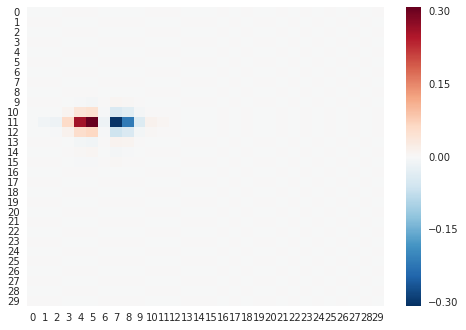

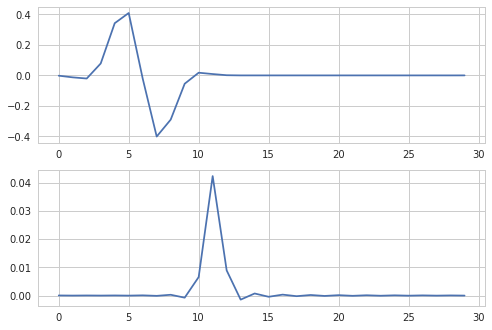

In [4]:
#Construct the filter
sres = nspec - 1 #resolution of the filter in pixels
tres = tlen      #time window of the filter in ms
maxfreq = 8000   #maximum frequency of the signal
latency = 50     #offset between stimulus and response in ms (range: 0 to time)
frequency = 4000 #centering frequency for the filter
A = 0.25         #amplitude of the wavelet peak -- probably don't need to change this
sigma = 0.05 #width of the filter in the time axis -- bigger sigma = narrower time band
gamma = 0.0015   #width of the filter in the frequency axis -- bigger gamma = narrower frequency band
alpha = 1        #depth of inhibitory sidebands on time axis -- bigger alpha = deeper sidebands
beta = 1         #depth of inhibitory sidebands on frequency axis -- bigger beta = deeper sidebands

filts = np.load('../filters.npz')
print(filts.keys())
k = filts['nbts']

k = resample(k,tres,axis=1)
k = resample(k,sres+1,axis=0)
#k = nfutils.normalize(k,center=False)

figure()
sns.heatmap(k,linewidths = 0)

figure()
B = np.sum(k,axis=1)
A = np.sum(k,axis=0)
subplot(211)
plot(A)
subplot(212)
plot(B)

# create cosine basis for time dimension
spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True)
costim = tot(tim)

matparam  = [10,2,0,10]


### Generating noisy data

In [5]:
# data settings
ntrials = 5
noise = 0
dataparam = np.hstack((spec[0],costim[0],matparam))
M = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,noise=noise,normalize=norm,center=center)
M.set(dataparam)

# generate the data
spikes_data = []
spiky_data = []
binary_data = []
model_data   = []
for s,dur in zip(stims,durations):
    dsdur = int(dur/t_dsample)
    sr = []
    sspk = []
    s0 = []
    sspiky = []
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        sspiky.append(pyspk.SpikeTrain(spikes,[0,dur]))
        s0.append(z)
    model_data.append(sr)
    spikes_data.append(sspk)
    spiky_data.append(sspiky)
    binary_data.append(s0)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=0) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 1.00


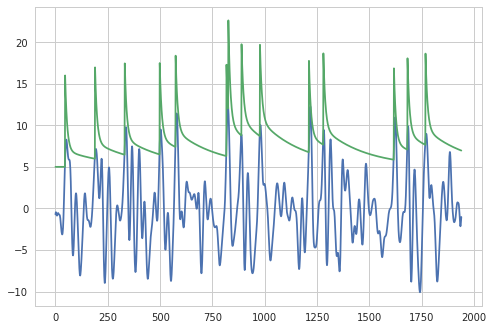

In [6]:
plot(model_data[-1][-1])

## Getting initial guess for STRF

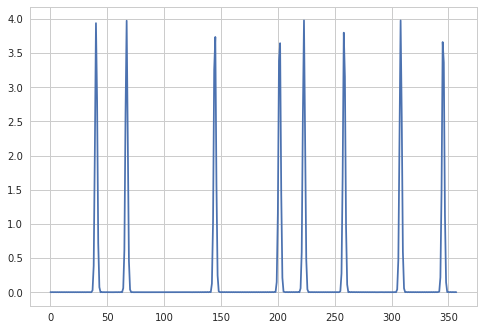

In [7]:
plot(10*psth_data[0])

In [12]:
%%time
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [np.log(p*1000 + 1) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False,l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
SPEC,TIM = utils.factorize(STRF_GUESS,1)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

CPU times: user 6min 48s, sys: 6min 15s, total: 13min 4s
Wall time: 5min 42s


In [111]:
from pyglmnet import GLM
from sklearn.preprocessing import StandardScaler

glm = GLM(distr='gaussian',verbose=True,reg_lambda=[0.01])
X,Y = utils.design_matrix(assim_stims,fit_psth,tlen)
Y = np.asarray([Y]).T
scaler = StandardScaler().fit(X)

In [ ]:
%%time
glm.fit(scaler.transform(X),Y)

Looping through the regularization path
Lambda: 0.0100


In [ ]:
glm.fit_[0]['beta']

0.326061737752


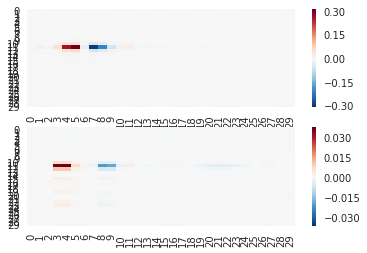

In [21]:
# plot true and estimated strf
subplot(211)
sns.heatmap(M.pstrf.filt)

subplot(212)
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [ ]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    #isi_dist = np.abs(np.mean([pyspk.isi_distance(spiky,trial) for trial in data]))
    dist = np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    #dist = isi_dist + spike_dist
    return dist*1000

def pploss(predict,data):
    trace,_ = predict
    spikes = data
    V,T = trace.T
    lam = np.exp(V-T)
    #lam,spikes = predict
    return -np.sum([np.sum(np.log(lam[s])) - np.sum(lam)*0.001 for s in spikes])

mat_prior = priors.joint_independent(
                [ nf.priors.uniform( -30,  30),
                  nf.priors.uniform( -30, 30),
                  nf.priors.uniform( -10, 10),
                  nf.priors.uniform(   0, 10)])

cost = spike_distance
unbounded = priors.unbounded()

def l1_prior(theta):
    return -np.sum(np.abs(theta))

def dstrf_prior(theta):
    return l1_prior(theta[:-4]) + mat_prior(theta[-4:])

## Run initial MAT parameter fit

In [ ]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts)

# generate starting positions of emcee walkers
p0 = startpos.uniform_independent(nwalkers,[-30,-30,-10,0],[30,30,10,10])
#p0 = startpos.normal_independent(nwalkers,[5,0,0,1],[0.1]*4)
#p0 = startpos.normal_independent(nwalkers,matparam,[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),threads)

burn = 5000
tracker = nfutils.convergence_tracker(burn,burn/10)

for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   500      -402.8     0:05:25     0:48:58
  1000     -347.41     0:10:57     0:43:53


Filt R: 0.446, MAT R: 0.941


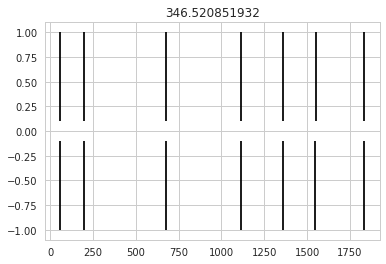

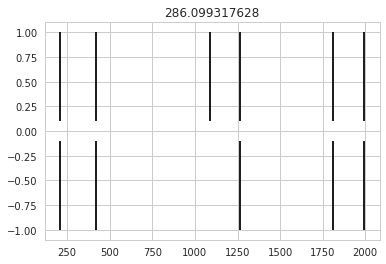

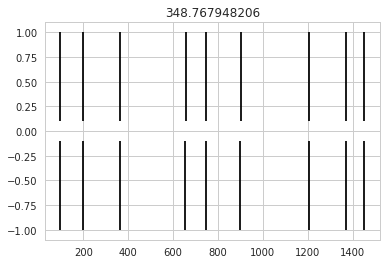

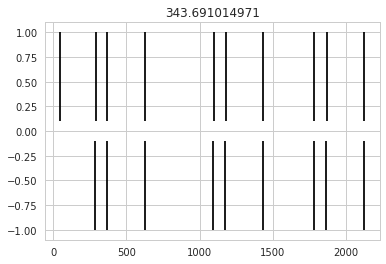

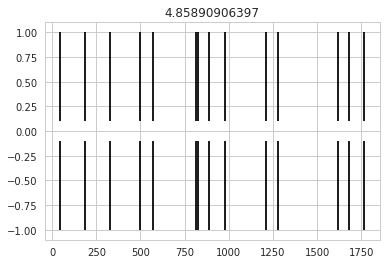

In [44]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat()
mat_map.set(mml)
mat_corr = []

STRF_GUESS = M.pstrf.filt

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d,s in zip(test_Iapp,test_psth,test_dur,test_spikes):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
    figure()
    vlines(spikes,0.1,1)
    vlines(s[0],-1,-0.1)
    
    title(spike_distance([trace,spikes],spiky_data[-1]))
    ylim(-1.1,1.1)
        
#start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

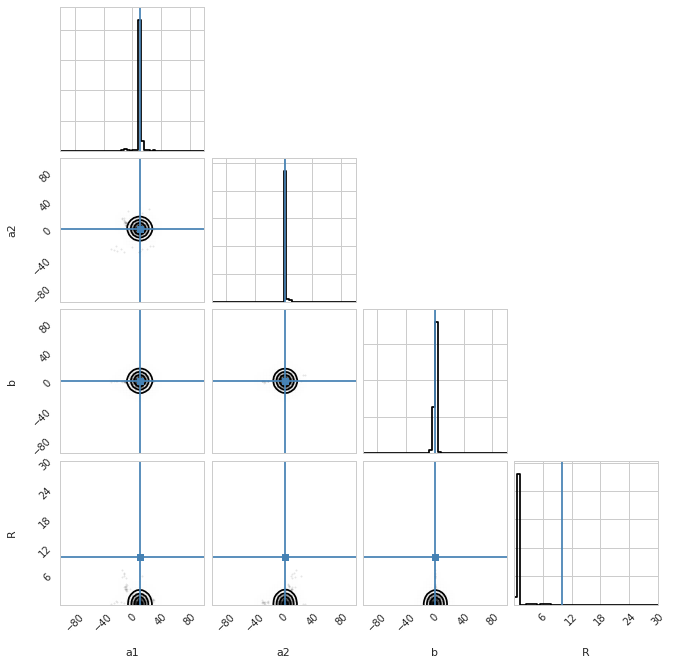

In [49]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','R']
c = corner(mat_smplr.flatchain,
       range=[[-100,100],
              [-100,100],
              [-100,100],
              [0,30]],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparam)

In [ ]:
V, thresh = trace.T
V[spikes] = 50
plot(V)
plot(thresh,"--",alpha=0.5)
xlim(0,500)

## Fit dSTRF model using emcee

In [154]:
# initalize the model
model = dstrf_mat(channels,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center)

# set starting positions for walkers
p01 = startpos.normal_independent(nwalkers,filt_start,[1e-1]*len(start))
p02 = startpos.uniform_independent(nwalkers,[-100,-10,-10,-10],[100,10,10,10])
#p0 = np.hstack((p0,mat_smplr.chain[:-1,0,:]))
#p0 = np.vstack((start,p0))
p0 = np.hstack((p01,p02))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_prior,spike_distance,nwalkers,zip(assim_stims,assim_spiky),threads)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

NameError: name 'filt_start' is not defined

## Evaluate the model fit

In [155]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))
# compare true and estimated STRFs
subplot(211)
sns.heatmap(M.pstrf.filt,)

subplot(212)
sns.heatmap(model.pstrf.filt)
tight_layout()

NameError: name 'dstrf_smplr' is not defined

In [46]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,test_spiky,t_dsample,psth_smooth)
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("MAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

NameError: name 'model' is not defined

In [47]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w']
c = corner(dstrf_smplr.flatchain[:,-4:],
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparam)

NameError: name 'dstrf_smplr' is not defined

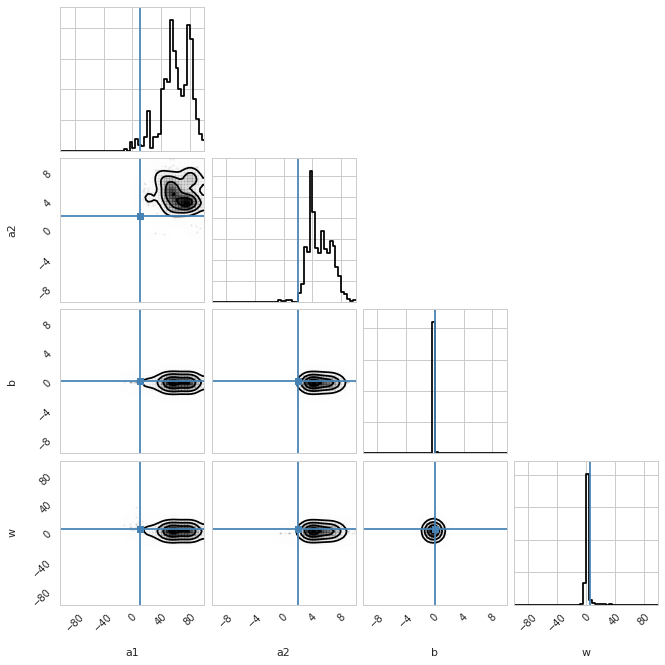

In [40]:
from corner import corner
sns.set_style("whitegrid")

matlabs = ['a1','a2','b','w']
c = corner(mat_smplr.flatchain,
       range=[[-100,100],
              [-10,10],
              [-10,10],
              [-100,100]],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparam)